In [16]:
%load_ext autoreload
%autoreload 2

import json
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import copy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Ablation data

In [17]:
# open store/results.json
with open('store/results.json', 'r') as f:
    cot_results = json.load(f)
nshot_df = pd.DataFrame.from_dict(cot_results, orient='index')
print(len(nshot_df))

cols_step_in = { # Select this if we want to leave the step-by-step IN
    0 : {'n_shot' : 0, 'step_by_step' : False, 'no_explanation' : False, 'desc': '0'},
    1 : {'n_shot' : 0, 'step_by_step' : True, 'no_explanation'  : False, 'desc': '0\n"Step-by-step"'},
    2 : {'n_shot' : 1, 'step_by_step' : False, 'no_explanation' : True,  'desc': '1'},
    3 : {'n_shot' : 2, 'step_by_step' : False, 'no_explanation' : True,  'desc': '2'},
    4 : {'n_shot' : 3, 'step_by_step' : False, 'no_explanation' : True,  'desc': '3'},
    5 : {'n_shot' : 4, 'step_by_step' : False, 'no_explanation' : True,  'desc': '4'},
    6 : {'n_shot' : 5, 'step_by_step' : False, 'no_explanation' : True,  'desc': '5'},
}

cols_step_out = { # Select this if we want to leave the step-by-step OUT
    0 : {'n_shot' : 0, 'step_by_step' : False, 'no_explanation' : False, 'desc': '0'},
    1 : {'n_shot' : 1, 'step_by_step' : False, 'no_explanation' : True,  'desc': '1'},
    2 : {'n_shot' : 2, 'step_by_step' : False, 'no_explanation' : True,  'desc': '2'},
    3 : {'n_shot' : 3, 'step_by_step' : False, 'no_explanation' : True,  'desc': '3'},
    4 : {'n_shot' : 4, 'step_by_step' : False, 'no_explanation' : True,  'desc': '4'},
    5 : {'n_shot' : 5, 'step_by_step' : False, 'no_explanation' : True,  'desc': '5'},
}

# abl_cols = cols_step_in
abl_cols = cols_step_out

abl_data = {'arithmetic' : {},'presuppositions_as_nli' : {}, }
for k, col in abl_cols.items():
    df_mode_acc =  nshot_df[(nshot_df['n_shot'] == col['n_shot']) & (nshot_df['step_by_step'] == col['step_by_step']) & (nshot_df['no_explanation'] == col['no_explanation'])][['model_id',  'accuracy', 'dataset_name']]

    for dataset_name in df_mode_acc['dataset_name'].unique():

        a = df_mode_acc[df_mode_acc['dataset_name'] == dataset_name]

        abl_data[dataset_name][k] = df_mode_acc[df_mode_acc['dataset_name'] == dataset_name].set_index('model_id').to_dict()['accuracy']

57


# Finetune data

In [18]:
# open store/results.json
with open('store/cot_results.json', 'r') as f:    
    cot_results = json.load(f)

# change the keys eval and train to 0 and 1, they are on the second level
cot_data = {k : {0 : v['eval'], 1 : v['train'], 2 : v['cot-eval'], 3 : v['cot-train']} for k, v in cot_results.items()}

cot_cols = {
    0 : {'desc' : '4-shot\n'},
    2 : {'desc' : '4-shot\nFinetune'},
    3 : {'desc' : '4-shot\nCoT'},
    5 : {'desc' : '4-shot\nCoT + \nFinetune'},
}

In [19]:
vals = lambda task, idx: np.array(list(cot_data[task][idx].values()))
increase = lambda task, new_idx, old_idx: np.mean((vals(task, new_idx) - vals(task, old_idx) ) / vals(task, old_idx) * 100)

# increases = np.array((increase(task, 1, 0), increase(task, 3, 2))) for task in list(cot_data.keys())]).flatten().round(0)

increases = {task : (increase(task, 1, 0), increase(task, 3, 2)) for task in list(cot_data.keys())}


# Let's plot!

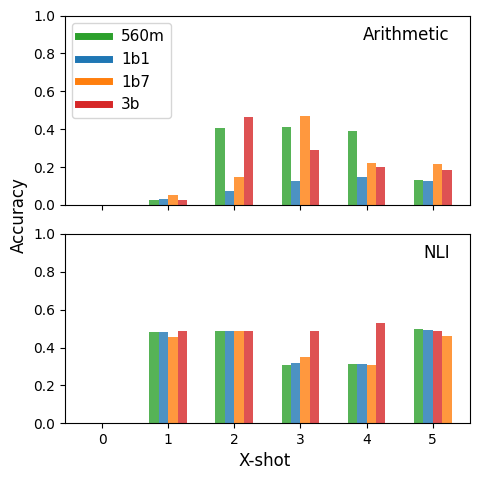

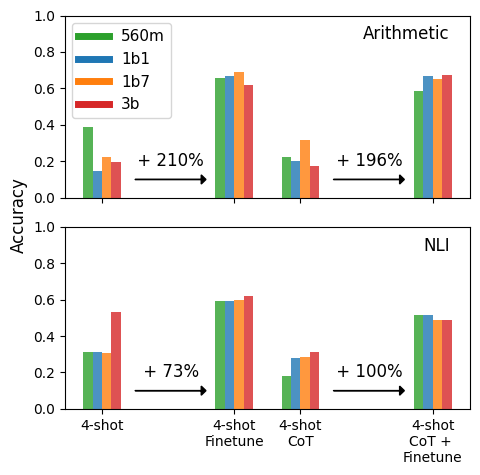

In [31]:
def plot(data, cols, xlabel, ylim = 1., increases = None):
    l = 1
    l2 = 7

    x_ticks = np.array(list(cols.keys()))*l2

    colors = {'bigscience/bloom-560m':'tab:green', 'bigscience/bloom-1b1':'tab:blue', 'bigscience/bloom-1b7':'tab:orange', 'bigscience/bloom-3b':'tab:red'}
    shapes = {'bigscience/bloom-560m':'o', 'bigscience/bloom-1b1':'P', 'bigscience/bloom-1b7':'^', 'bigscience/bloom-3b':'s'}
    shift =  {0 : -1.5*l, 1: -l*0.5, 2: l*0.5, 3: 1.5*l}
    tasks = {'arithmetic' : 'Arithmetic', 'presuppositions_as_nli' : 'NLI'}

    handles = [
        Line2D([0], [0], color=color, lw=5, label=label.split('-')[-1]) for label, color in colors.items()
    ]

    fig, axs = plt.subplots(len(data), 1, figsize=(5*len(data)/2, 2.5*2), sharey=True, sharex=True, tight_layout=True)

    for (task, data_task), ax in zip(data.items(), axs):
        task

        for k, d in data_task.items():
            vals = list(d.values())
            keys = list(d.keys())
            x = [k] * len(vals)

            for i, (val, key) in enumerate(zip(vals, keys)):
                # ax.plot(x_ticks[k] + shift[i], [val], marker = shapes[key] , color = colors[key], alpha=0.8)
                    ax.bar(x_ticks[k] + shift[i], [val] , width = 1., color = colors[key], alpha=0.8)
            # ax.scatter(x, vals, c = [colors[k] for k in keys], alpha=0.5)

        ax.set_xticks(x_ticks)
        ax.set_xticklabels([v['desc'] for v in cols.values()])
        # axs[1].set_xlabel('X-shot')
        ax.set_title(tasks[task], y = 0.9, x = .95, ha = 'right', va = 'top')
        ax.set_ylim([0, ylim])

        if increases is not None:
            for i, x in enumerate([1, 4]):
                ax.text(x*l2, 0.2, f' + {increases[task][i]:.0f}%', va='center', ha='center', fontsize=12)
                ax.arrow((x-0.5)*l2, 0.1, l2, 0, head_width = 0.05, head_length = 0.5, fc='k', ec='k')

    # axs[0].set_ylabel('Accuracy')
    axs[0].legend(handles = handles, loc = 'upper left', ncol = 1, fontsize = 11)
    # axs[0].tick_params(right = True)
    # axs[1].tick_params(labelright = True, right = True)

    # fig.suptitle('Performance without CoT or finetuning')
    fig.supylabel('Accuracy', x = 0.05, y = 0.56)
    fig.supxlabel(xlabel, y = 0.05, x = 0.56, ha = 'center', va = 'bottom')

    
    plt.show()

plot(abl_data, abl_cols, xlabel = 'X-shot')
plot(cot_data, cot_cols, xlabel = '', increases=increases)



In [21]:
assert False

AssertionError: 

# Unified plots
*(probably broken right now)*

In [ ]:
# Unify data and cols
unified_data = copy.deepcopy(data)
# unified_cols = copy.deepcopy(cols)
for task in data.keys():
    for cot_idx in cot_data[task].keys():
        unified_cot_idx = len(data[task]) + cot_idx
        unified_data[task][unified_cot_idx] = cot_data[task][cot_idx]
        # unified_cols[unified_cot_idx] = cot_cols[cot_idx]


unified_xtick_labels = ["0-shot", "1-shot", "2-shot", "3-shot", "4-shot", "5-shot", "4-shot\n w/ CoTs", "4-shot\nw/ CoTs\n+ fine-tuning"]

print(unified_data)

{'arithmetic': {0: {'bigscience/bloom-560m': 0.0, 'bigscience/bloom-1b1': 0.0, 'bigscience/bloom-1b7': 0.0, 'bigscience/bloom-3b': 0.0}, 1: {'bigscience/bloom-560m': 0.024793388429752067, 'bigscience/bloom-1b1': 0.03305785123966942, 'bigscience/bloom-1b7': 0.049586776859504134, 'bigscience/bloom-3b': 0.024793388429752067}, 2: {'bigscience/bloom-560m': 0.4049586776859504, 'bigscience/bloom-1b1': 0.0743801652892562, 'bigscience/bloom-1b7': 0.1487603305785124, 'bigscience/bloom-3b': 0.4628099173553719}, 3: {'bigscience/bloom-560m': 0.4132231404958678, 'bigscience/bloom-1b1': 0.12396694214876033, 'bigscience/bloom-1b7': 0.47107438016528924, 'bigscience/bloom-3b': 0.2892561983471074}, 4: {'bigscience/bloom-560m': 0.3884297520661157, 'bigscience/bloom-1b1': 0.1487603305785124, 'bigscience/bloom-1b7': 0.2231404958677686, 'bigscience/bloom-3b': 0.19834710743801653}, 5: {'bigscience/bloom-560m': 0.1322314049586777, 'bigscience/bloom-1b1': 0.12396694214876033, 'bigscience/bloom-1b7': 0.214876033

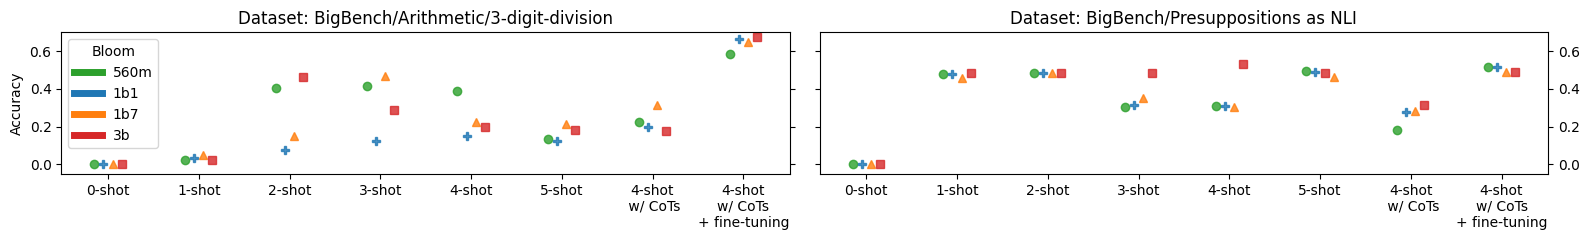

In [ ]:
l = 1
l2 = 10

x_ticks = np.arange(len(unified_xtick_labels))*l2

colors = {'bigscience/bloom-560m':'tab:green', 'bigscience/bloom-1b1':'tab:blue', 'bigscience/bloom-1b7':'tab:orange', 'bigscience/bloom-3b':'tab:red'}
shapes = {'bigscience/bloom-560m':'o', 'bigscience/bloom-1b1':'P', 'bigscience/bloom-1b7':'^', 'bigscience/bloom-3b':'s'}
shift =  {0 : -1.5*l, 1: -l*0.5, 2: l*0.5, 3: 1.5*l}
tasks = {'arithmetic' : 'Dataset: BigBench/Arithmetic/3-digit-division', 'presuppositions_as_nli' : 'Dataset: BigBench/Presuppositions as NLI'}

handles = [
    Line2D([0], [0], color=color, lw=5, label=label.split('-')[-1]) for label, color in colors.items()
]

fig, axs = plt.subplots(1, len(unified_data), figsize=(8*len(unified_data), 2.5), sharey=True, sharex=True, tight_layout=True)

for (task, data_task), ax in zip(unified_data.items(), axs):

    for k, d in data_task.items():
        vals = list(d.values())
        keys = list(d.keys())
        x = [k] * len(vals)

        for i, (val, key) in enumerate(zip(vals, keys)):
            ax.plot(x_ticks[k] + shift[i], [val], marker = shapes[key] , color = colors[key], alpha=0.8)
        # ax.scatter(x, vals, c = [colors[k] for k in keys], alpha=0.5)

    ax.set_xticks(x_ticks)
    ax.set_xticklabels(unified_xtick_labels)
    # ax.set_xlabel('Setting')
    ax.set_title(tasks[task])
    ax.set_ylim([-0.05, ylim])

axs[0].set_ylabel('Accuracy')
axs[0].legend(handles = handles, loc = 'upper left', title = 'Bloom')
axs[0].tick_params(right = True)
axs[1].tick_params(labelright = True, right = True)

# fig.suptitle('Performance without CoT or finetuning')
# fig.tight_layout()
plt.show()
